<a href="https://colab.research.google.com/github/Olhaau/fl-official-statistics-addon/blob/main/_dev/02_insurance_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Insurance - a Federated Learning Use Case.

This notebook contains: **Deep Neural Networks Experiments (centralized)**




## Setup
---

In [1]:
# Is a repo-clone and installs needed (e.g. in colabs)? 
need_clone_install = False

### Pull Repo

In [4]:
if need_clone_install:
    import os
    
    # rm repo from gdrive
    if os.path.exists("fl-official-statistics-addon"):
      %rm -r fl-official-statistics-addon

    # clone
    !git clone https://github.com/Olhaau/fl-official-statistics-addon
    %cd fl-official-statistics-addon

    # pull (the currenct version of the repo)
    !git pull

### Installs

In [5]:
if need_clone_install:
    !pip install --quiet tensorflow_addons
    #optional for tuning and visualization:
    !pip install --quiet keras_tuner
    !pip install --quiet autokeras
    !pip install --quiet keras_visualizer 

### Imports

In [8]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
from glob import glob

# ML
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# DNN
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow_addons.metrics import RSquare

# Tuning + Visualization
#import keras_tuner # -> error
import keras_visualizer as kv 
from keras.utils.vis_utils import plot_model
from IPython.display import Image

os.chdir("..")

### Ingest Data

In [9]:
df = pd.read_csv("output/data/insurance-clean.csv", index_col = 0)
df.head()

,age,sex,bmi,children,smoker,region,charges,region0,region1,region2,region3
0,0.021739,0.0,0.321227,0.0,1.0,southwest,16884.92400,0.0,0.0,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0,southeast,1725.55230,0.0,0.0,1.0,0.0
2,0.217391,1.0,0.458434,0.6,0.0,southeast,4449.46200,0.0,0.0,1.0,0.0
3,0.326087,1.0,0.181464,0.0,0.0,northwest,21984.47061,0.0,1.0,0.0,0.0
4,0.304348,1.0,0.347592,0.0,0.0,northwest,3866.85520,0.0,1.0,0.0,0.0


#### Train Test Split

In [10]:
# Divide data into train and test data
features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region0', 'region1', 'region2', 'region3']
target = 'charges'

df_ml = df[features + [target]]

X_train, X_test, y_train, y_test = train_test_split(
    df_ml[features], df_ml[[target]], 
    test_size=0.2, random_state=42, shuffle = True)

## DNN Support
---

### DNN Template

In [11]:
from sklearn.metrics import r2_score
# default = DNN model of the original repo
# compose and compile

def create_model(
    feature_count = 9,
    activations = ['relu', 'relu'],
    units = [32, 16],
    dropout_frac = 0.05,
    loss = 'mae',
    optimizer = tf.optimizers.SGD(),
    metrics=["mae", 'mean_squared_error', r2_score]):
  """
  Returns a composed and compiled 2-layered Keras Model.
  """ 
  model = Sequential([
      keras.Input(shape=(feature_count,)),
      Dense(units = units[0], activation=activations[0]),
      Dropout(dropout_frac),
      Dense(units = units[1], activation=activations[1]),
      Dense(1)
  ])

  model.compile(
      loss = loss, 
      optimizer = optimizer, 
      metrics=metrics, 
      run_eagerly=True
      )
  
  return model

# should be faster, but does not work:
#from tensorflow_addons.metrics import RSquare
#dnn_model.compile(loss='mse', optimizer='rmsprop', metrics=[RSquare()], run_eagerly=True)
# S. https://stackoverflow.com/questions/45250100/kerasregressor-coefficient-of-determination-r2-score
dnn_model = create_model()
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                320       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 865 (3.38 KB)
Trainable params: 865 (3.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Diagnostic Plot

In [12]:
# diagnostics plot
def plot_loss(history, y_min=None, y_max=None, save_path=None, title = None):
    """Plot the training history and save the figure.

    :param history: The history object including the metrics to plot
    :type history: keras.callbacks.History
    :param y_min: The lover limit of the plot
    :type y_min: float, optional
    :param y_max: The upper limit of the plot
    :type y_max: float, optional
    :param save_path: The path to save the plot, if None, it will not be saved
    :type save_path: str, optional
    """
    plt.plot(history.history['r2_score'], label='train R^2')
    plt.plot(history.history['val_r2_score'], label='eval R^2')
    if y_min is not None and y_max is not None:
        plt.ylim([y_min, y_max])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    if save_path is not None:
        plt.savefig(save_path)

### DNN Plot

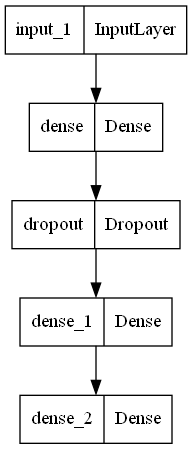

In [13]:
plot_model(dnn_model)

#alternatively
#!pip install --quiet visualkeras
#import visualkeras
#visualkeras.layered_view(dnn_model, legend=True, draw_volume=False)

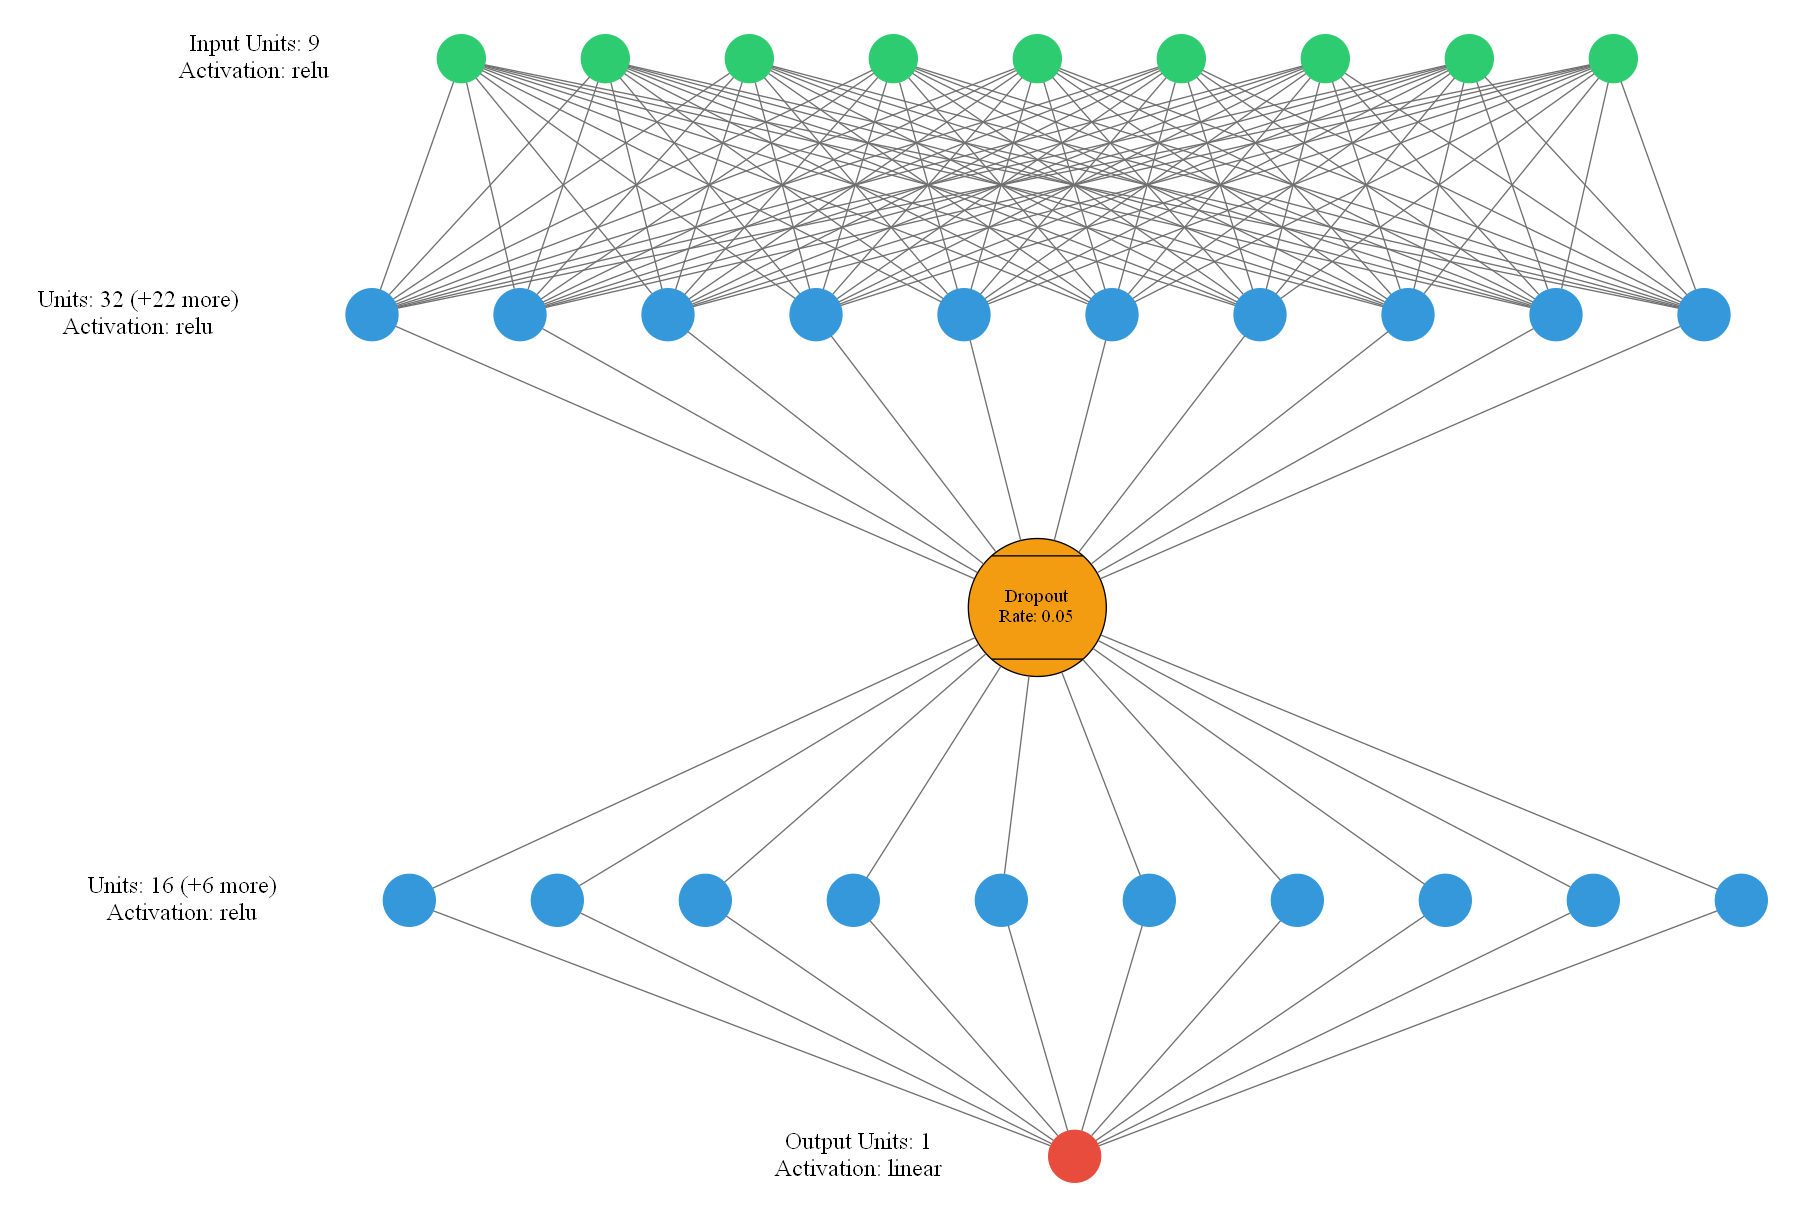

In [14]:
#or a pretty plot (as file)
kv.visualizer(dnn_model, file_format = 'png', file_name = 'output/plots/_original_model', view=True)
Image('output/plots/_original_model.png')

## Experiments
---

In [15]:
# Experiment Setup
validation_split_size = 0.2
epochs_def = 100

plot_experiment_path = "output/plots/dnn_experiments"
if not os.path.exists(plot_experiment_path): os.makedirs(plot_experiment_path)

### Original Model

test R^2 = 82.08 %


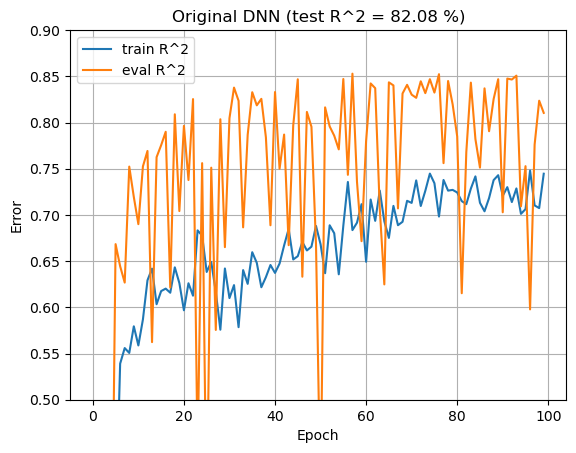

In [16]:
tf.random.set_seed(42)
dnn_model = create_model()

#train
dnn_history = dnn_model.fit(
    X_train, y_train,
    shuffle=True,
    validation_split = validation_split_size,
    epochs = epochs_def, verbose = 0
    )
#output
r2_str = "test R^2 = {:.2f} %".format(100 * dnn_history.model.evaluate(X_test, y_test, verbose = 0)[-1])
print(r2_str)
plot_loss(dnn_history, y_min = 0.5, y_max = 0.9, 
          title = "Original DNN (" + r2_str + ")"
          , save_path = plot_experiment_path + "/00_original_performance")

### Lower Learnrate 

test R^2 = 83.59 %


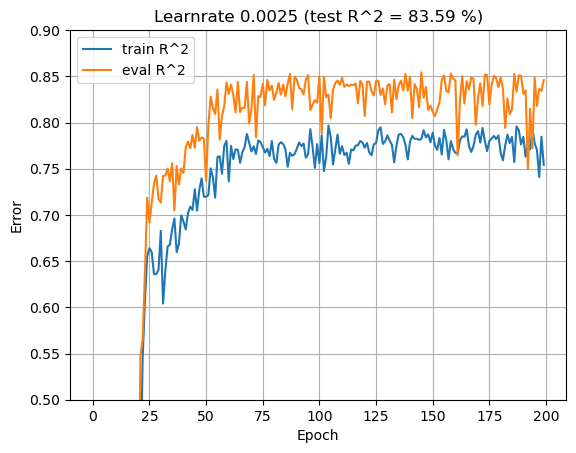

In [17]:
# create_model
tf.random.set_seed(42)
dnn_model = create_model(optimizer = tf.optimizers.SGD(learning_rate = .0025))

#train
dnn_history = dnn_model.fit(
    X_train, y_train,
    shuffle = True,
    validation_split = validation_split_size,
    epochs = epochs_def * 2, verbose = 0
    )

#output
r2_str = "test R^2 = {:.2f} %".format(100 * dnn_history.model.evaluate(X_test, y_test, verbose = 0)[-1])
print(r2_str)
plot_loss(dnn_history, y_min = 0.5, y_max=0.9, 
          title = "Learnrate 0.0025 (" + r2_str + ")"
          , save_path = plot_experiment_path + "/01_low-learnrate-0p0025")

### Low LR + Adam

test R^2 = 69.49 %


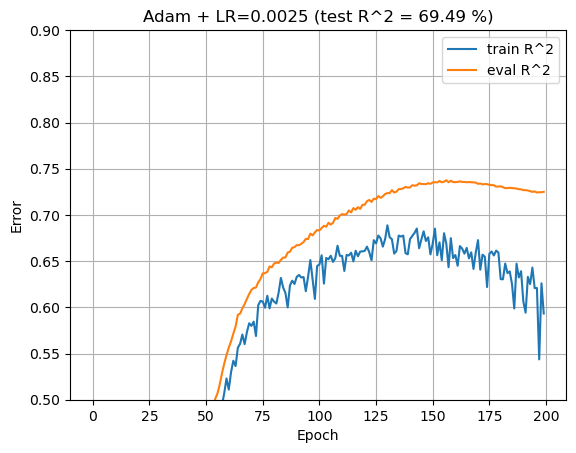

In [18]:
# create_model
tf.random.set_seed(42)
dnn_model = create_model(optimizer = tf.optimizers.Adam(learning_rate = .0025))

#train
dnn_history = dnn_model.fit(
    X_train, y_train,
    shuffle = True,
    validation_split = validation_split_size,
    epochs = epochs_def * 2, verbose = 0
    )
#output
r2_str = "test R^2 = {:.2f} %".format(100 * dnn_history.model.evaluate(X_test, y_test, verbose = 0)[-1])
print(r2_str)
plot_loss(dnn_history, y_min = 0.5, y_max=0.9, 
          title = "Adam + LR=0.0025 (" + r2_str + ")"
          , save_path = plot_experiment_path + "/02_adam-low-learnrate-0p0025")

test R^2 = 64.36 %


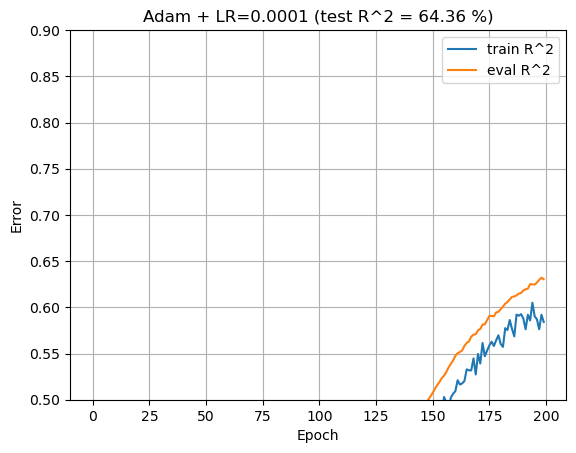

In [19]:
# create_model
tf.random.set_seed(42)
dnn_model = create_model(optimizer = tf.optimizers.Adam(learning_rate = .001))

#train
dnn_history = dnn_model.fit(
    X_train, y_train,
    shuffle = True,
    validation_split = validation_split_size,
    epochs = epochs_def * 2, verbose = 0
    )

#output
r2_str = "test R^2 = {:.2f} %".format(100 * dnn_history.model.evaluate(X_test, y_test, verbose = 0)[-1])
print(r2_str)
plot_loss(dnn_history, y_min = 0.5, y_max=0.9, 
          title = "Adam + LR=0.0001 (" + r2_str + ")"
          , save_path = plot_experiment_path + "/02_adam-low-learnrate-0p001")

test R^2 = 81.48 %


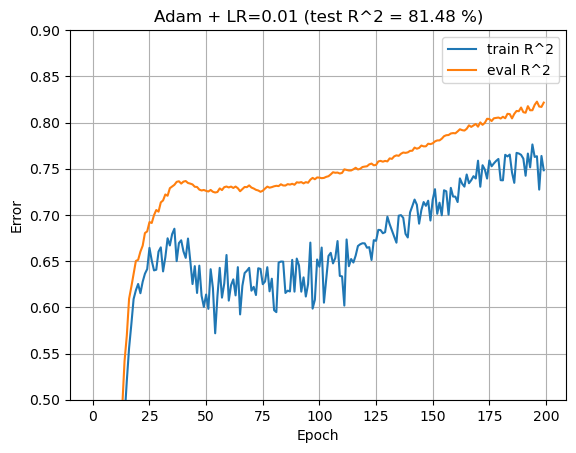

In [29]:
# create_model
tf.random.set_seed(42)
dnn_model = create_model(optimizer = tf.optimizers.Adam(learning_rate = .01))

#train
dnn_history = dnn_model.fit(
    X_train, y_train,
    shuffle = True,
    validation_split = validation_split_size,
    epochs = epochs_def * 2, verbose = 0
    )

#output
r2_str = "test R^2 = {:.2f} %".format(100 * dnn_history.model.evaluate(X_test, y_test, verbose = 0)[-1])
print(r2_str)
plot_loss(dnn_history, y_min = 0.5, y_max = 0.9, 
          title = "Adam + LR=0.01 (" + r2_str + ")"
          , save_path = plot_experiment_path + "/02_adam-low-learnrate-0p01")

test R^2 = 85.13 %


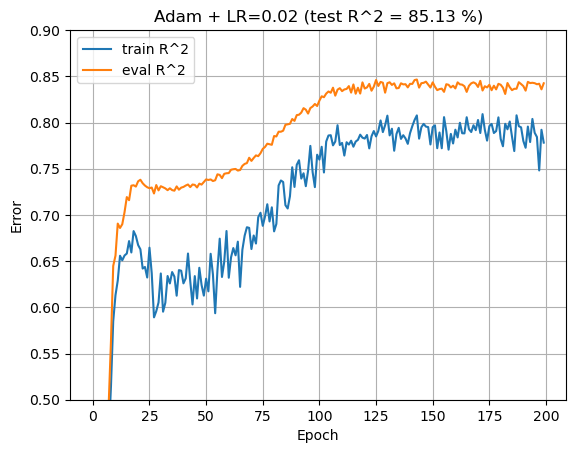

In [30]:
# create_model
tf.random.set_seed(42)
dnn_model = create_model(optimizer = tf.optimizers.Adam(learning_rate = .02))

#train
dnn_history = dnn_model.fit(
    X_train, y_train,
    shuffle = True,
    validation_split = validation_split_size,
    epochs = epochs_def * 2, verbose = 0
    )

#output
r2_str = "test R^2 = {:.2f} %".format(100 * dnn_history.model.evaluate(X_test, y_test, verbose = 0)[-1])
print(r2_str)
plot_loss(dnn_history, y_min = 0.5, y_max = 0.9, 
          title = "Adam + LR=0.02 (" + r2_str + ")"
          , save_path = plot_experiment_path + "/02_adam-low-learnrate-0p02")

### Seperated Regions

In [20]:
X_train_r0 = X_train[X_train.region0 == 1].iloc[:,0:5]
X_test_r0  = X_test[X_test.region0 == 1].iloc[:,0:5]
y_train_r0 = y_train[X_train.region0 == 1]
y_test_r0 = y_test[X_test.region0 == 1]

X_train_r1 = X_train[X_train.region1 == 1].iloc[:,0:5]
X_test_r1  = X_test[X_test.region1 == 1].iloc[:,0:5]
y_train_r1 = y_train[X_train.region1 == 1]
y_test_r1 = y_test[X_test.region1 == 1]

X_train_r2 = X_train[X_train.region2 == 1].iloc[:,0:5]
X_test_r2  = X_test[X_test.region2 == 1].iloc[:,0:5]
y_train_r2 = y_train[X_train.region2 == 1]
y_test_r2 = y_test[X_test.region2 == 1]

X_train_r3 = X_train[X_train.region3 == 1].iloc[:,0:5]
X_test_r3  = X_test[X_test.region3 == 1].iloc[:,0:5]
y_train_r3 = y_train[X_train.region3 == 1]
y_test_r3 = y_test[X_test.region3 == 1]

test R^2 = 76.78 %


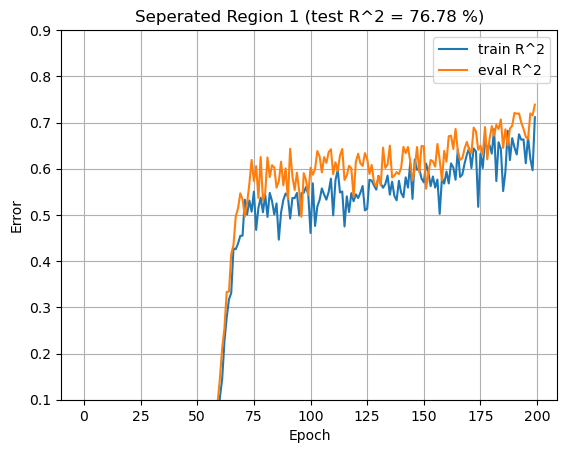

In [25]:
# create_model
tf.random.set_seed(42)
dnn_model = create_model(
    feature_count = 5,
    optimizer = tf.optimizers.SGD(learning_rate = .0025)
    )

# train
dnn_history = dnn_model.fit(
    X_train_r0,
    y_train_r0,
    shuffle=True,
    validation_split = validation_split_size,
    verbose=0,
    epochs = epochs_def * 2
    )


#output
r2_str = "test R^2 = {:.2f} %".format(100 * dnn_history.model.evaluate(X_test_r0, y_test_r0, verbose = 0)[-1])
print(r2_str)
plot_loss(dnn_history, y_min = 0.1, y_max=0.9, 
          title = "Seperated Region 1 (" + r2_str + ")"
          , save_path = plot_experiment_path + "/03_seperated-regions1")

test R^2 = 78.58 %


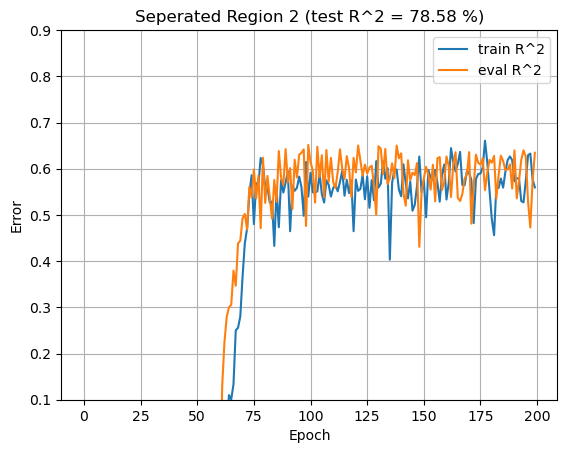

In [26]:
# create_model
tf.random.set_seed(42)
dnn_model = create_model(
    feature_count = 5,
    optimizer = tf.optimizers.SGD(learning_rate = .0025)
    )

# train
dnn_history = dnn_model.fit(
    X_train_r1,
    y_train_r1,
    shuffle=True,
    validation_split = validation_split_size,
    verbose=0,
    epochs=epochs_def * 2)


#output
r2_str = "test R^2 = {:.2f} %".format(100 * dnn_history.model.evaluate(X_test_r1, y_test_r1, verbose = 0)[-1])
print(r2_str)
plot_loss(dnn_history, y_min = 0.1, y_max=0.9, 
          title = "Seperated Region 2 (" + r2_str + ")"
          , save_path = plot_experiment_path + "/03_seperated-regions2")

test R^2 = 88.00 %


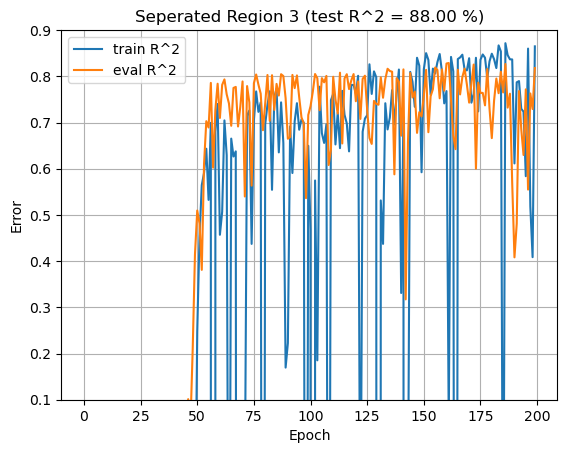

In [27]:
# create_model
tf.random.set_seed(42)
dnn_model = create_model(
    feature_count = 5,
    optimizer = tf.optimizers.SGD(learning_rate = .0025)
    )

# train
dnn_history = dnn_model.fit(
    X_train_r2,
    y_train_r2,
    shuffle=True,
    validation_split = validation_split_size,
    verbose=0,
    epochs=epochs_def * 2)


#output
r2_str = "test R^2 = {:.2f} %".format(100 * dnn_history.model.evaluate(X_test_r2, y_test_r2, verbose = 0)[-1])
print(r2_str)
plot_loss(dnn_history, y_min = 0.1, y_max=0.9, 
          title = "Seperated Region 3 (" + r2_str + ")"
          , save_path = plot_experiment_path + "/03_seperated-regions3")

test R^2 = 49.47 %


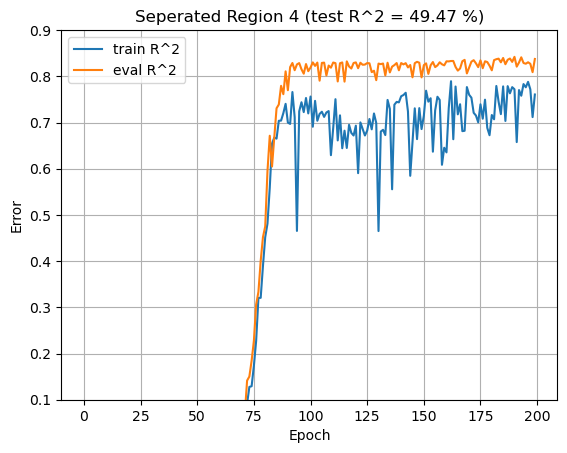

In [28]:
# create_model
tf.random.set_seed(42)
dnn_model = create_model(
    feature_count = 5,
    optimizer = tf.optimizers.SGD(learning_rate = .0025)
    )
# train
dnn_history = dnn_model.fit(
    X_train_r3,
    y_train_r3,
    shuffle=True,
    validation_split = validation_split_size,
    verbose=0,
    epochs=epochs_def * 2)


#output
r2_str = "test R^2 = {:.2f} %".format(100 * dnn_history.model.evaluate(X_test_r3, y_test_r3, verbose = 0)[-1])
print(r2_str)
plot_loss(dnn_history, y_min = 0.1, y_max=0.9, 
          title = "Seperated Region 4 (" + r2_str + ")"
          , save_path = plot_experiment_path + "/04_seperated-regions3")

## Results

- the original training is unstable (Variance in Train/Eval Performance is sometimes very high).
- A lower learnrate (and Adam Optimizer) showed improvments.
- The Variance differs for execution of the experiment on different runtimes, systems and calculation of R^2 -> cross validation should be used.
- The Performance differs for each region, which can be responsible for problems in the federated scenario.



## Next Steps

- Use Cross-Validation to stabelize the experiments.
- Tune the DNN specification, the used optimizer and learnrate.
- Only use the most stable regions in the federated scenario.
